# Sentiment Analysis with BERT

> In this exercise, we will obtain and fine-tune BERT base model for sentiment analysis. We'll do the required text preprocessing such as adding special tokens, padding, and attention masks. Finally we will build a Sentiment Classifier using the amazing Transformers library provided by Hugging Face.

We will:
- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict sentiment on raw text

#### Source:
Comprehensive tutorial on sentiment classification: https://youtu.be/8N-nM3QW7O0

BERT Paper: https://arxiv.org/abs/1810.04805

Attention is All you Need: https://arxiv.org/abs/1706.03762

Encoding words with context: https://arxiv.org/abs/1802.05365v2

In [3]:
!nvidia-smi

Tue Aug 10 14:55:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup

We'll need the Transformers library by Hugging Face, so we'll go ahead and download it:

In [2]:
!pip install -q -U watermark

In [4]:
!pip install -qq transformers

     |████████████████████████████████| 2.6 MB 3.9 MB/s 
     |████████████████████████████████| 3.3 MB 23.4 MB/s 
     |████████████████████████████████| 636 kB 39.3 MB/s 
     |████████████████████████████████| 895 kB 42.1 MB/s 


In [5]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.11
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.9.0+cu102
transformers: 4.9.2



In [6]:
#@title Setup & Config
# We'll perfomr some quick setup, these will come in handy later when
# we train and evaluate our model.
# We will also be using the GPU mostly for our mdoeling, as recommended by the BERT paper.
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## EDA

We'll load the Google Play app reviews dataset, gathered from the tutorial:

In [7]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 36.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 22.9MB/s]


In [8]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [9]:
df.shape

(15746, 11)

We have about 16k examples. Let's check for missing values:

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


No missing values in the score and review texts! Do we have class imbalance?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


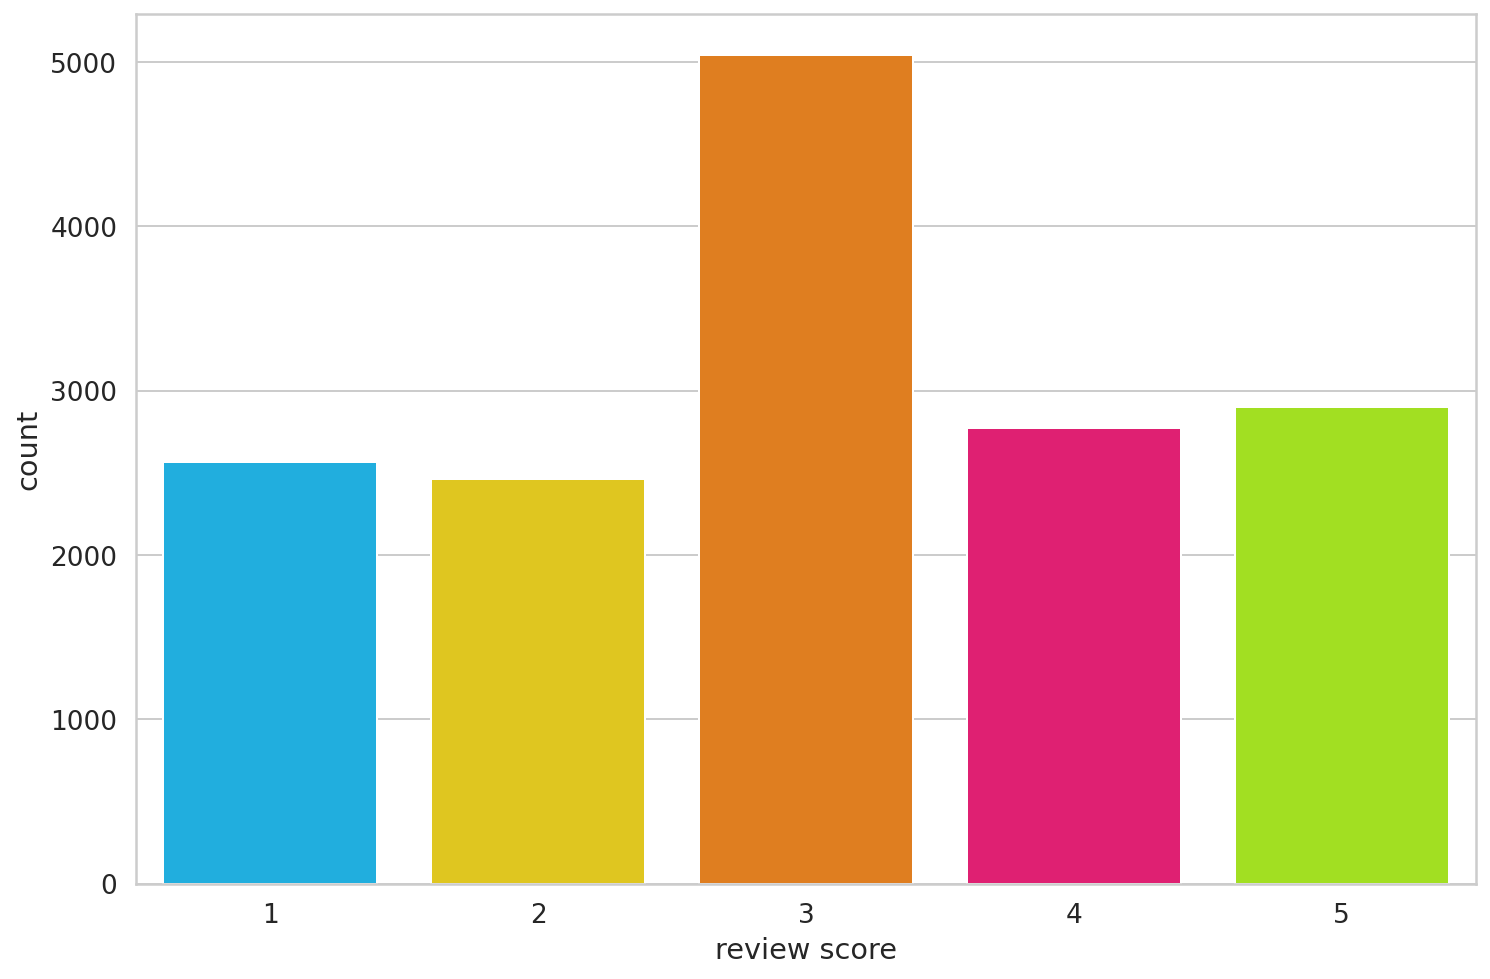

In [11]:
sns.countplot(df.score)
plt.xlabel('review score');

Our dataset is initialy hugely imbalanced, but that's fine,
We will convert the dataset into negative, neutral and positive sentiment, totaling 3 classes.

In [12]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [13]:
class_names = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


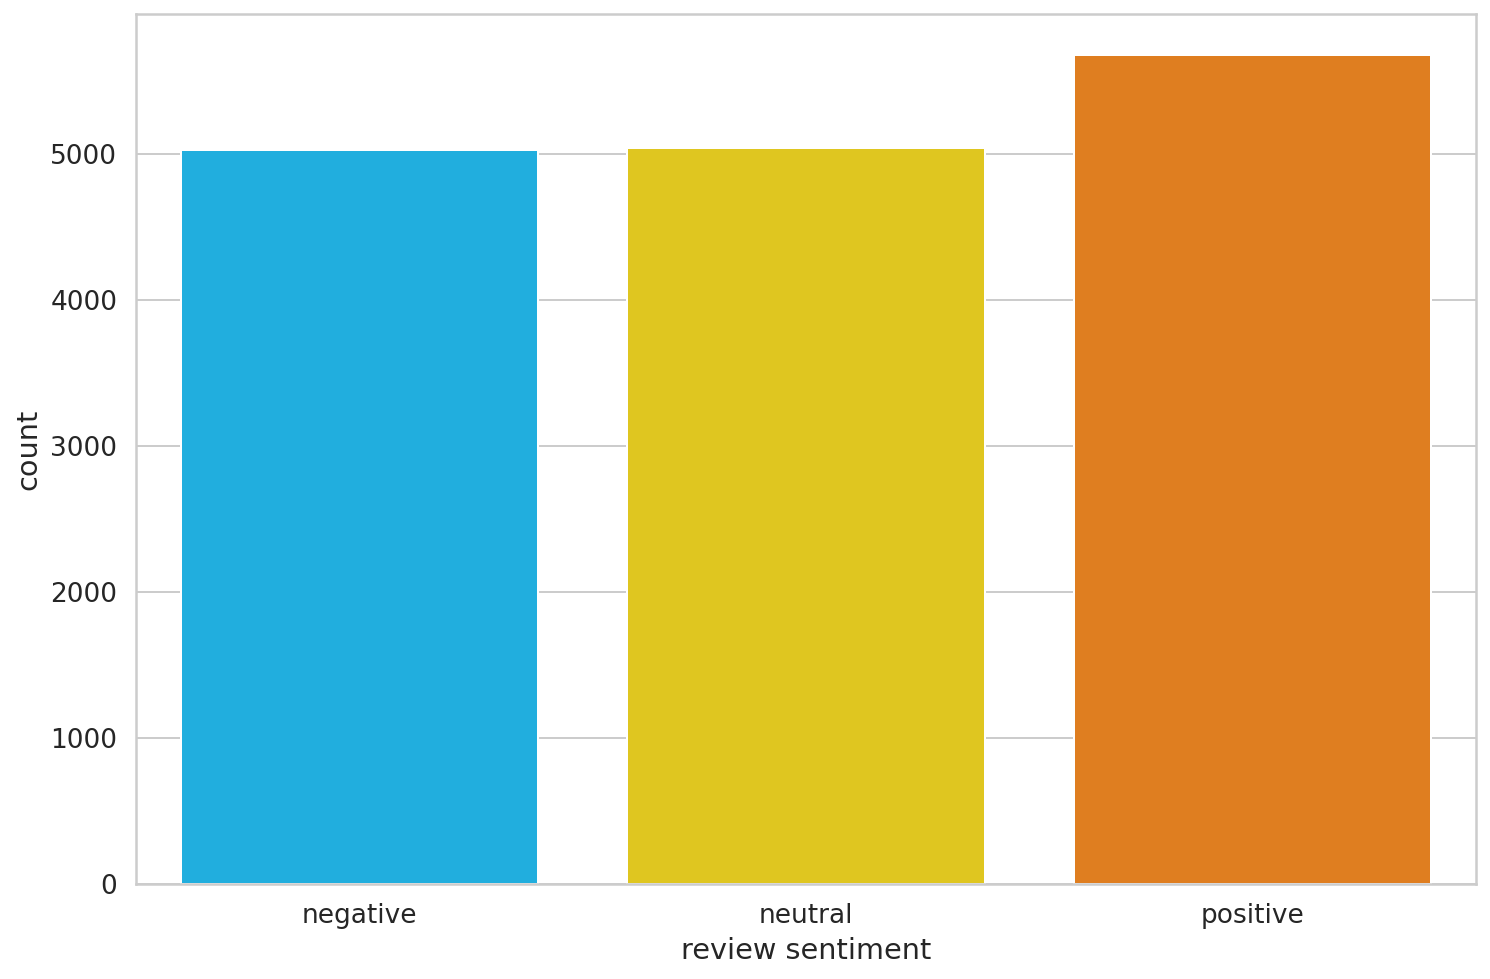

In [14]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

The balance is mostly restored after our custom scoring. Next, we need to pre-process our data so pytorch can handle it.

## Data Preprocessing
Since Machine Learning models don't work with raw text, We need to convert all the text to numbers. BERT requires even more attention, pun intended.
We need to effectively: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding to fill up empty spaces)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides a wide variety of Transformer models including BERT. It works with TensorFlow and PyTorch, for the purpose of our exercise we will be using pytorch.
It also includes prebuilt tokenizers that will do the heavy lifting for us.


In [15]:
# We will use the case-sensitive model since more context may be attributed to cased words or sentences.
 
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

We will use the case-sensitive model since more context may be attributed to cased words or sentences. The cased version simply works better. Intuitively, that makes sense, since "HEY!" might convey more sentiment than "hey".

Let's load a pre-trained Bert Tokenizer next

In [16]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

We'll use this text to understand the tokenization process:

In [17]:
sample_txt = 'Machine Learning is not as hard as previously thought. Things have obviously gotten easier over the years!'

We run some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [18]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Machine Learning is not as hard as previously thought. Things have obviously gotten easier over the years!
   Tokens: ['Machine', 'Learning', 'is', 'not', 'as', 'hard', 'as', 'previously', 'thought', '.', 'Things', 'have', 'obviously', 'gotten', 'easier', 'over', 'the', 'years', '!']
Token IDs: [7792, 9681, 1110, 1136, 1112, 1662, 1112, 2331, 1354, 119, 7149, 1138, 5544, 4690, 5477, 1166, 1103, 1201, 106]


### Special Tokens

`[SEP]` - marker for ending of a sentence


In [19]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [20]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [21]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [22]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [23]:
# Our method converts our input natural text into a form that pytorch will understand,
# In this case, a tensor.
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

# A look at what is contained in our encoding.
encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [24]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 7792, 9681, 1110, 1136, 1112, 1662, 1112, 2331, 1354,  119, 7149,
        1138, 5544, 4690, 5477, 1166, 1103, 1201,  106,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

The attention mask has the same length:

In [25]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [26]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Machine',
 'Learning',
 'is',
 'not',
 'as',
 'hard',
 'as',
 'previously',
 'thought',
 '.',
 'Things',
 'have',
 'obviously',
 'gotten',
 'easier',
 'over',
 'the',
 'years',
 '!',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [27]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

and plot the distribution:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


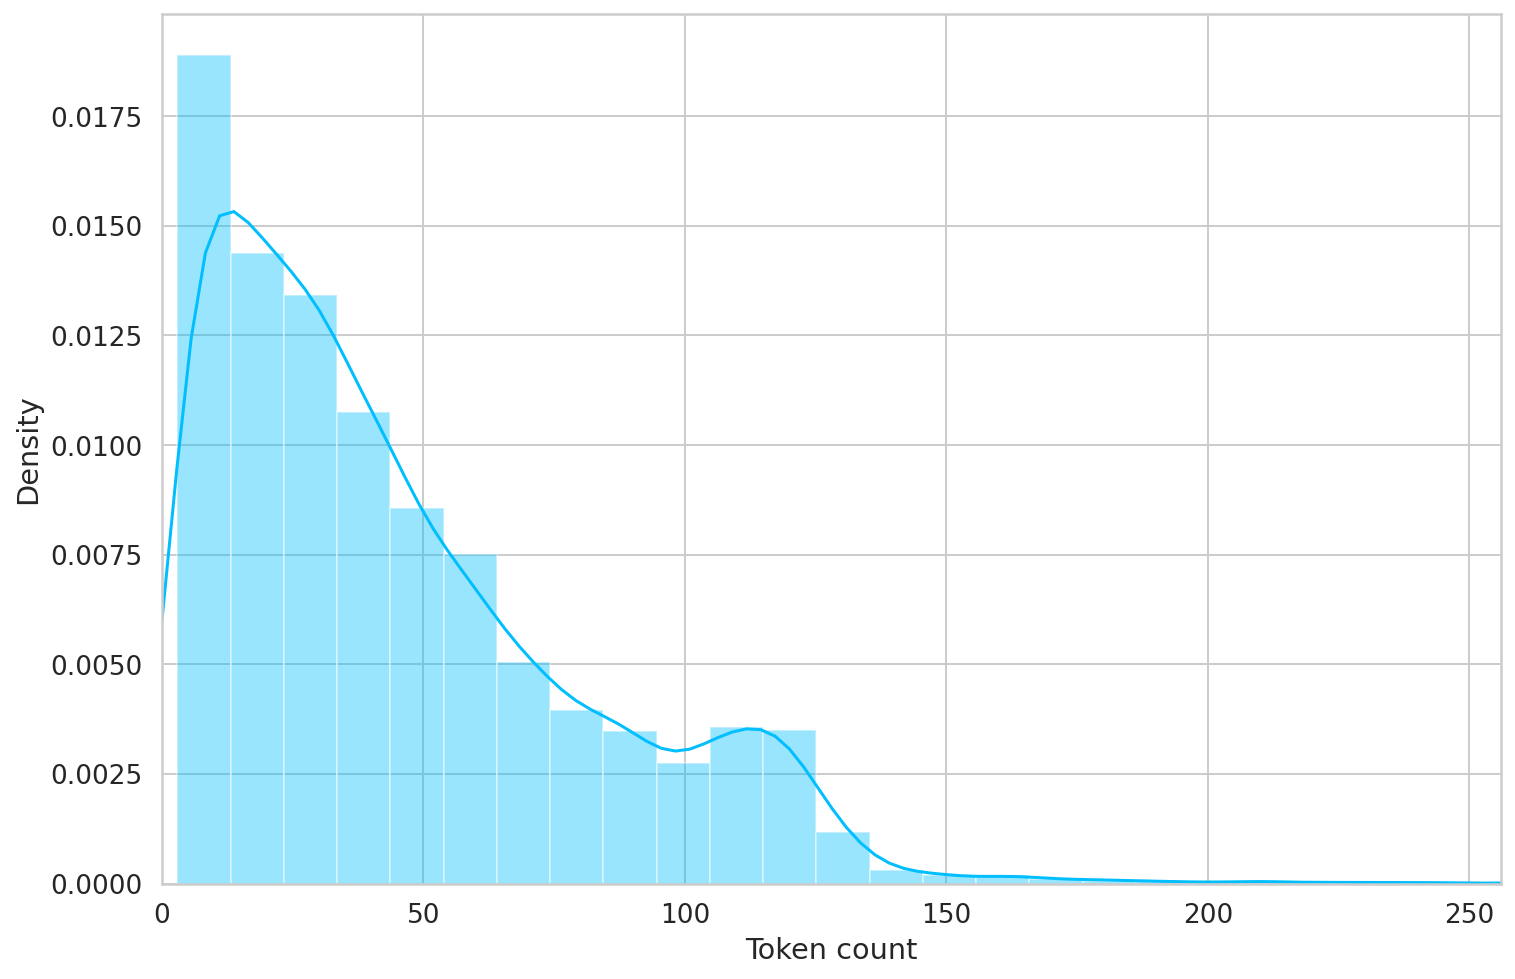

In [28]:
# We realize that most of our sentences have a token length below 170
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [29]:
# We will therefore set our maximum token length to 160
MAX_LEN = 160

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [30]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer does most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. From there we split our data into test, train and validation sets.

In [31]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [138]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

In [35]:
# Saving test_data_loader for use later in our api
df_test.to_csv(r'test_data_loader.csv', index=False)

We also need to create a couple of data loaders. Here's a helper function to do it. Our data loader will take our data set, divide them into batches and tokenize them. It will return a format that will be easier for us to handle.

In [32]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [33]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [144]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [145]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use BertForSequenceClassification or BertForQuestionAnswering. For our use case we'll use the basic BERT model and build our sentiment classifier on top of it using transfer learning.

In [146]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


And try to use it on the encoding of our sample text:

In [147]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
  return_dict = False   # this is needed to get a tensor as result, instead of a dict of str
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the BertPooler on `last_hidden_state`:

In [148]:
last_hidden_state.shape

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [149]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [150]:
pooled_output.shape

torch.Size([1, 768])


We will then create a classifier that uses the BERT model:

In [151]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

We create an instance and delegate it to the GPU

In [152]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We'll move the example batch of our training data to the GPU:

In [153]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [154]:
# Apply softmax to our output.
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1204, 0.6684, 0.2112],
        [0.2199, 0.6026, 0.1775],
        [0.2296, 0.4709, 0.2995],
        [0.5203, 0.3198, 0.1599],
        [0.3184, 0.5231, 0.1586],
        [0.2138, 0.3109, 0.4753],
        [0.3024, 0.5757, 0.1220],
        [0.2923, 0.5399, 0.1678],
        [0.3870, 0.2564, 0.3566],
        [0.3070, 0.4375, 0.2555],
        [0.3362, 0.3992, 0.2645],
        [0.2681, 0.4044, 0.3274],
        [0.3257, 0.3443, 0.3300],
        [0.3158, 0.4028, 0.2814],
        [0.3341, 0.3938, 0.2720],
        [0.2872, 0.2977, 0.4151]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Training

To reproduce the training procedure from the BERT paper, we'll use the AdamW optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We will then use 4 epochs are recommended by the paper.We'll also use a linear scheduler with no warmup steps to train our model.

In [155]:
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

For the purpose of our exercise, we will stick with the recommendation.
Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

We will then have a helper function for training our model for one epoch.

In [156]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model has some interesting paramters.
The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model by clipping the gradient when neccesary.

We will also have another helper that will help us evaluate our model based on
our data loader.

In [157]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can then write our training loop. We'll also store the training history:

In [ ]:
# Or we can save ourselves some time and download our previously trained model from GDrive:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

In [158]:
# We'll keep track of the time.
# This will probably take a while.

%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  # We will save the best state of our model as a binary file
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.7320119772047544 accuracy 0.6675605109025475


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5712235802412033 accuracy 0.7611181702668361

Epoch 2/4
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.4192437924713771 accuracy 0.83797897113824


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.49827622637152674 accuracy 0.8310038119440916

Epoch 3/4
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.23493735668376617 accuracy 0.9214593183261591


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5618205611407757 accuracy 0.855146124523507

Epoch 4/4
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.15154119663565413 accuracy 0.9510267447604263


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6184451602818445 accuracy 0.8640406607369759

CPU times: user 27min 43s, sys: 2min 8s, total: 29min 51s
Wall time: 29min 59s


After training, we will store the state of the best model, indicated by the highest validation accuracy.
We can retrieve this later and perform our prediction and classification instead of going through the whole training process again.

### Evaluating Our Model


It took a while to train our model. More epochs will definitely be better, if we spend more time training our model.
We can look at the training vs validation accuracy:

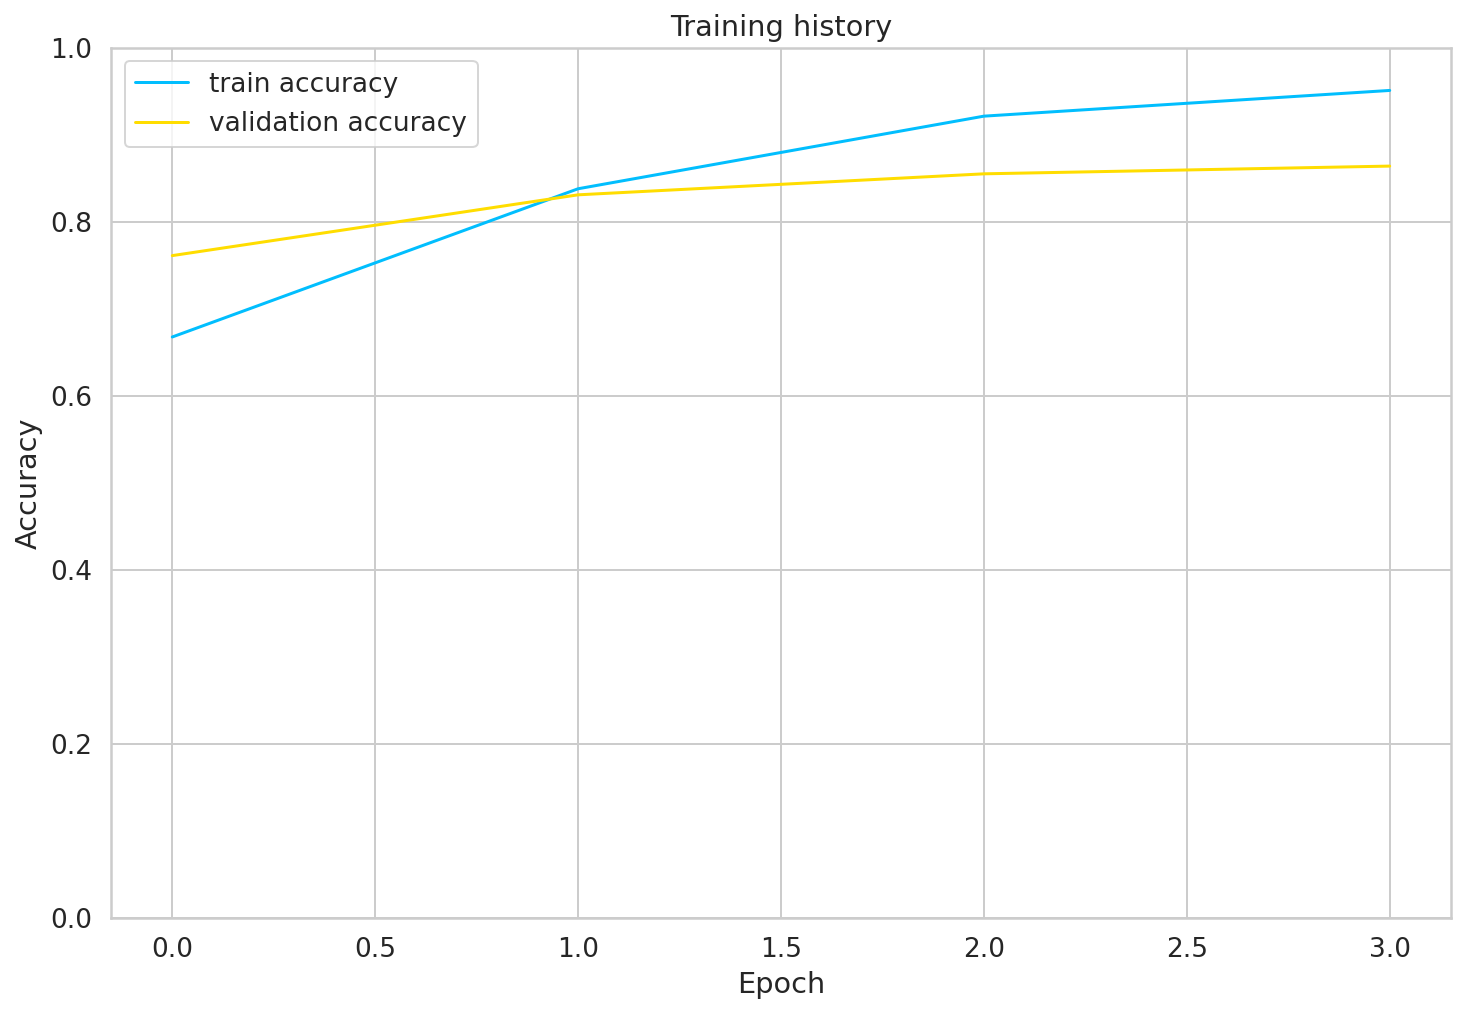

In [159]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

We are guessing the training accuracy starts to approach 100% after 10 epochs or so. We could try to fine-tune the parameters a bit more, but this will be good enough for us.

In [160]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('./best_model_state.bin'))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [161]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

0.8705583756345177

The accuracy is about 2% higher on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model.

In [162]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [163]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Let's have a look at the classification report

In [164]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.91      0.86      0.88       245
     neutral       0.79      0.86      0.82       254
    positive       0.92      0.89      0.90       289

    accuracy                           0.87       788
   macro avg       0.87      0.87      0.87       788
weighted avg       0.87      0.87      0.87       788



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

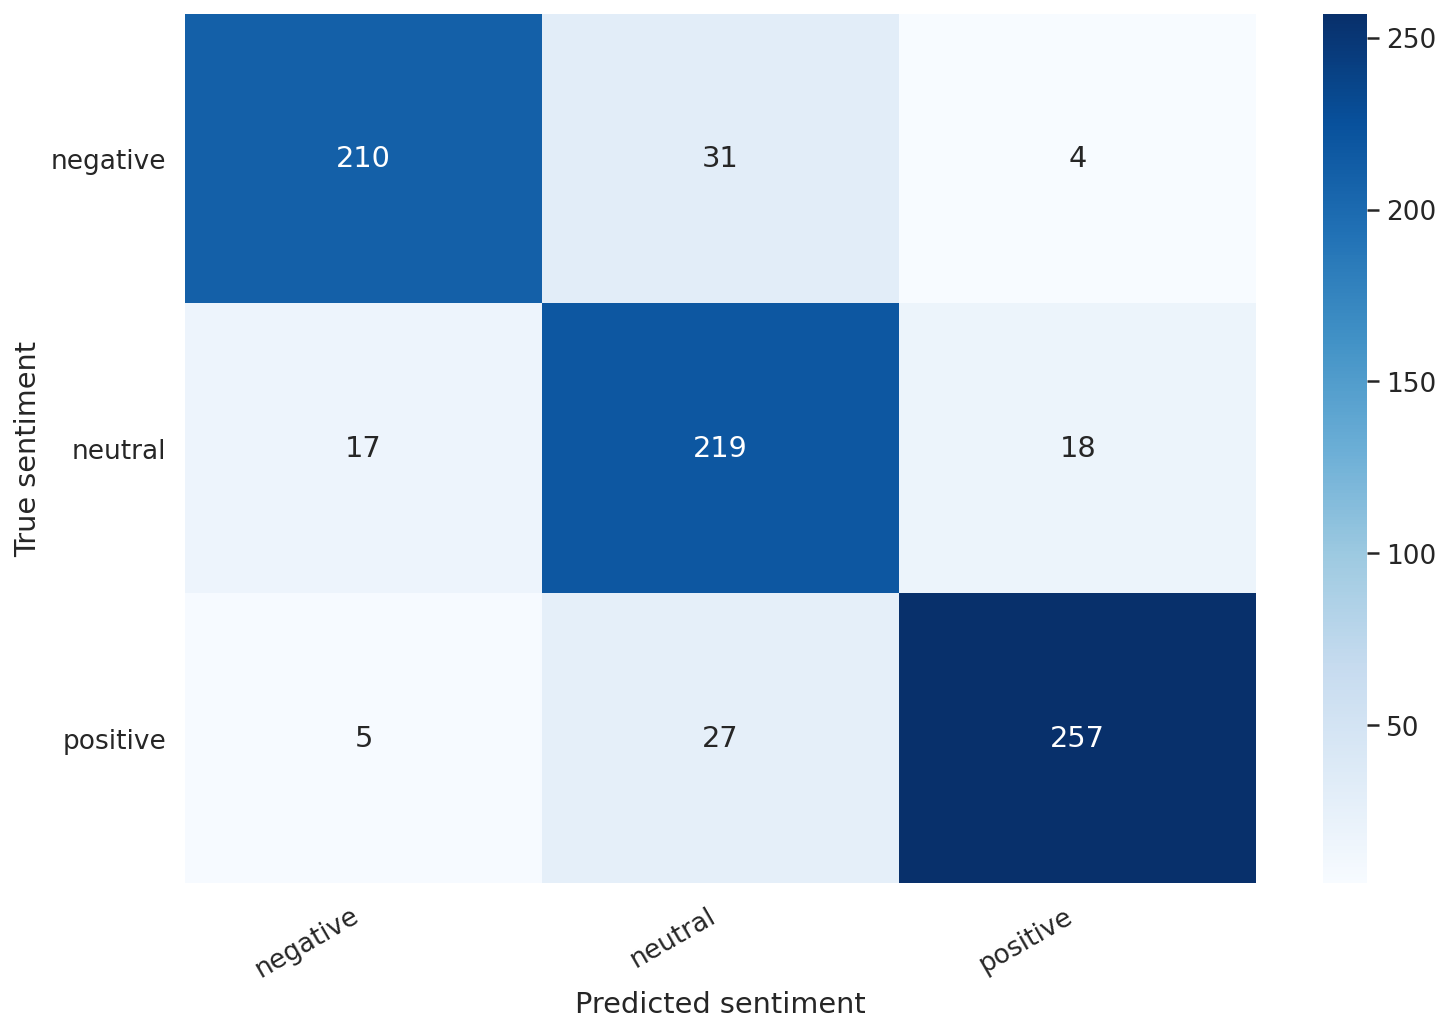

In [165]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data.

In [168]:
idx = 6

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [169]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Good

True sentiment: positive


Now we can look at the confidence of each sentiment of our model:

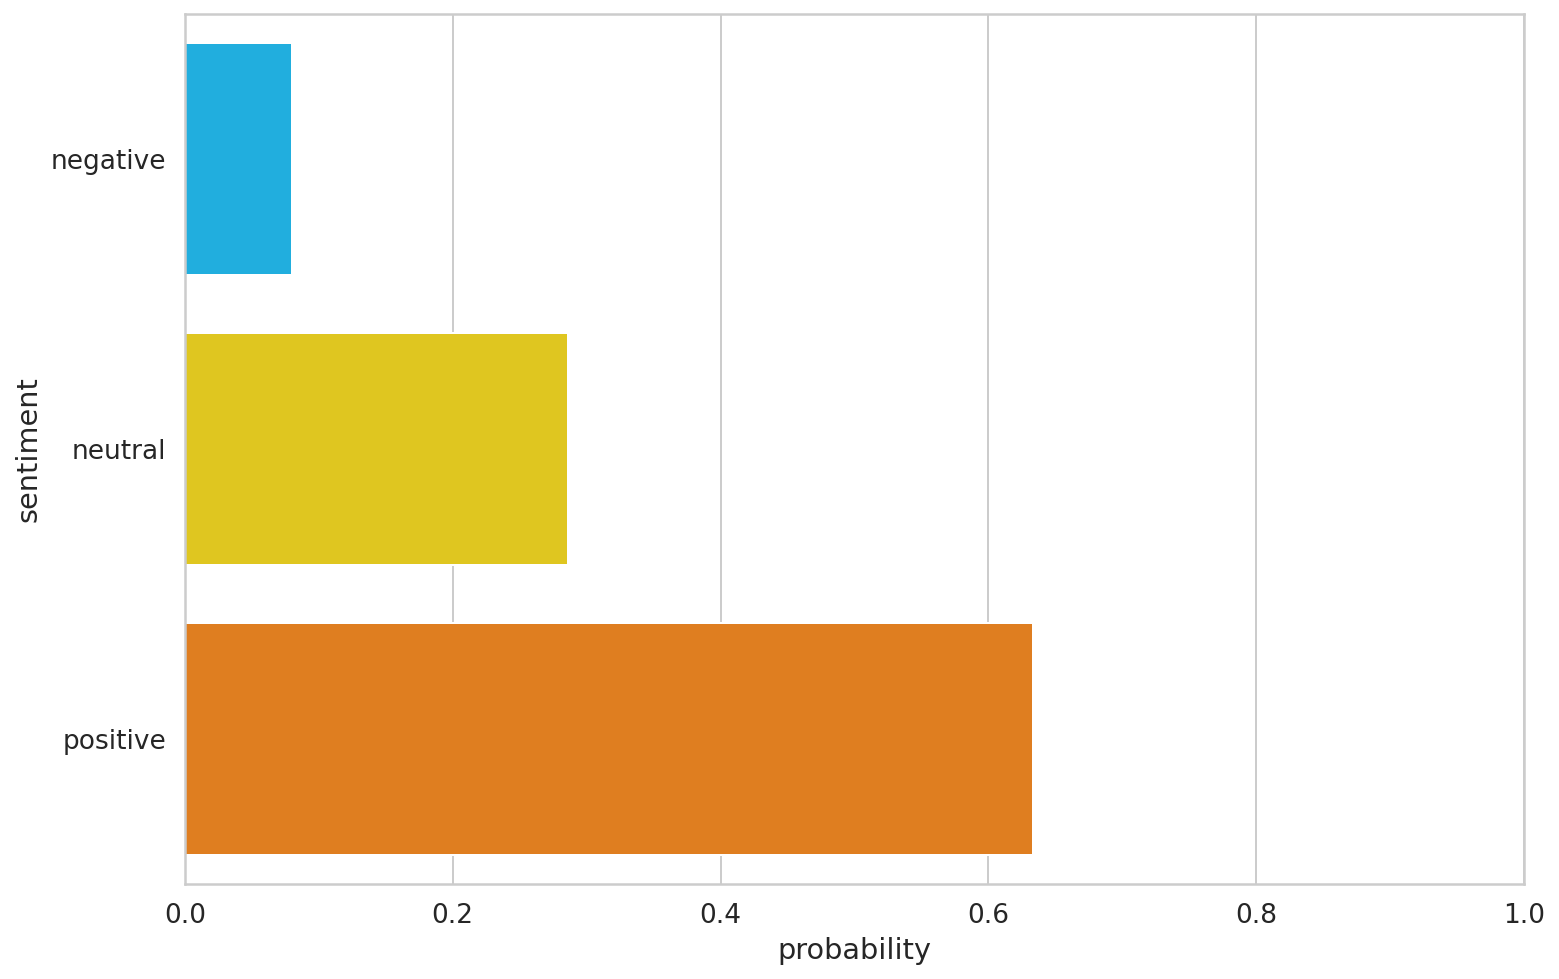

In [170]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [171]:
review_text = "I couldn't figure this out. Worst app ever!"

We have to use the tokenizer to encode the text:

In [172]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Let's get the predictions from our model:

In [173]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I couldn't figure this out. Worst app ever!
Sentiment  : negative


## Conclusion

In this exercise, we used BERT for sentiment analysis. We built a custom classifier using the Hugging Face library and trained it on our app reviews dataset, and validated our model with the validation set. We achieved quite a high level of accuracy, with our model generalizing well.
Our attention mask helped us protect the context of our embeddings, overall resulting in a much accurate understanding of what we saying by our model.
In conclusion, we did a lot less work than if we had to implement this from scratch.




## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)

- [Read the `Getting Things Done with Pytorch`](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)